In [17]:
# Empezamos llamando a las librerías con las que vamos a trabajar.
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, PageBreak
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.enums import TA_CENTER, TA_LEFT
import numpy as np
from datetime import datetime

In [18]:
# CONFIGURACIÓN INICIAL 
carpeta_csv = r"D:\Beltrán\Segundo año TS CD e IA\Modelizado de Minería de Datos\TSCIA_MMD\Proyecto_3\CSVs_originales"
carpeta_proyecto = r"D:\Beltrán\Segundo año TS CD e IA\Modelizado de Minería de Datos\TSCIA_MMD\Proyecto_3"

archivos_csv = glob.glob(os.path.join(carpeta_csv, "*.csv"))

if not archivos_csv:
    print(" No se encontraron archivos CSV en la carpeta especificada.")
else:
    print(f" Se encontraron {len(archivos_csv)} archivos CSV:")
    for a in archivos_csv:
        print(" -", os.path.basename(a))

# Crear carpetas de salida en la carpeta Proyecto_3
carpeta_excels = os.path.join(carpeta_proyecto, "Excels_Individuales")
carpeta_graficos_combinados = os.path.join(carpeta_proyecto, "Graficos_Combinados")
carpeta_informe_combinado = os.path.join(carpeta_proyecto, "Informe_Combinado")

os.makedirs(carpeta_excels, exist_ok=True)
os.makedirs(carpeta_graficos_combinados, exist_ok=True)
os.makedirs(carpeta_informe_combinado, exist_ok=True)

# Archivo combinado final en la carpeta Proyecto_3 (sin subcarpeta)
salida_excel_combinado = os.path.join(carpeta_proyecto, "Datos_Combinados.xlsx")

 Se encontraron 13 archivos CSV:
 - clientes.csv
 - cliente_mail.csv
 - cliente_telefono.csv
 - condicion_iva.csv
 - factura_det.csv
 - factura_enc.csv
 - localidades.csv
 - pais.csv
 - productos.csv
 - proveedores.csv
 - provincias.csv
 - rubro.csv
 - sucursales.csv


In [19]:
# --- FUNCIÓN PARA CARGAR TABLAS CON FORMATO CORRECTO ---
def cargar_tablas(archivos_csv):
    """
    Carga todos los CSV con los formatos correctos basados en los archivos proporcionados
    """
    dataframes = {}
    
    for archivo in archivos_csv:
        nombre = os.path.splitext(os.path.basename(archivo))[0]
        print(f"\n Cargando {nombre}...")
        
        try:
            # Cargar el CSV
            df = pd.read_csv(archivo, delimiter=';')
            print(f"   Columnas originales: {list(df.columns)}")
            print(f"   Primeras filas:")
            print(df.head(3))
            
            # Limpiar nombres de columnas (eliminar comillas y espacios)
            df.columns = df.columns.str.replace('"', '').str.strip()
            
            # Procesamiento específico para cada tabla basado en los archivos reales
            if 'clientes' in nombre.lower() and 'mail' not in nombre.lower() and 'telefono' not in nombre.lower():
                # Tabla clientes principal
                df.columns = ['id_cliente', 'nombre_completo', 'dni', 'direccion', 'id_localidad']
                print(f"   Tabla clientes procesada")
                
            elif 'cliente_mail' in nombre.lower():
                # Tabla cliente_mail
                df.columns = ['id_cliente', 'email']
                print(f"   Tabla cliente_mail procesada")
                
            elif 'cliente_telefono' in nombre.lower():
                # Tabla cliente_telefono
                df.columns = ['id_cliente', 'telefono']
                print(f"   Tabla cliente_telefono procesada")
                
            elif 'factura_det' in nombre.lower():
                # Tabla factura_det
                df.columns = ['id_detalle', 'id_factura', 'id_producto', 'cantidad']
                print(f"   Tabla factura_det procesada")
                
            elif 'factura_enc' in nombre.lower():
                # Tabla factura_enc - ESTRUCTURA CORREGIDA
                df.columns = ['id_factura', 'numero_factura', 'fecha', 'condicion_iva_id', 'id_sucursal']
                print(f"   Tabla factura_enc procesada (estructura actualizada)")
                
            elif 'productos' in nombre.lower():
                # Tabla productos
                df.columns = ['id_producto', 'nombre_producto', 'precio', 'id_proveedor', 'id_rubro']
                print(f"   Tabla productos procesada")
                
            elif 'rubro' in nombre.lower():
                # Tabla rubro
                df.columns = ['id_rubro', 'nombre_rubro']
                print(f"   Tabla rubro procesada")
                
            elif 'sucursales' in nombre.lower():
                # Tabla sucursales
                df.columns = ['id_sucursal', 'nombre_sucursal', 'id_localidad', 'id_provincia']
                print(f"   Tabla sucursales procesada")
                
            elif 'localidades' in nombre.lower():
                # Tabla localidades
                df.columns = ['id_localidad', 'nombre_localidad', 'id_provincia']
                print(f"   Tabla localidades procesada")
                
            elif 'provincias' in nombre.lower():
                # Tabla provincias
                df.columns = ['id_provincia', 'nombre_provincia', 'id_pais']
                print(f"   Tabla provincias procesada")
                
            elif 'pais' in nombre.lower():
                # Tabla pais
                df.columns = ['id_pais', 'nombre_pais']
                print(f"   Tabla pais procesada")
                
            elif 'condicion_iva' in nombre.lower():
                # Tabla condicion_iva
                df.columns = ['id_condicion_iva', 'descripcion']
                print(f"   Tabla condicion_iva procesada")
                
            elif 'proveedores' in nombre.lower():
                # Tabla proveedores
                df.columns = ['id_proveedor', 'nombre_proveedor', 'telefono', 'email', 'alias', 'banco']
                print(f"   Tabla proveedores procesada")
            
            dataframes[nombre] = df
            print(f"   Columnas finales: {list(df.columns)}")
            print(f"   Filas: {len(df)}")
            
        except Exception as e:
            print(f"   ERROR cargando {nombre}: {e}")
    
    return dataframes


In [20]:
# --- FUNCIÓN PARA GENERAR GRÁFICOS COMBINADOS ---
def generar_graficos_combinados(dataframes, carpeta_graficos):
    """
    Genera gráficos específicos combinando las tablas correctamente
    """
    graficos_generados = []
    
    print("\n=== IDENTIFICANDO TABLAS ===")
    
    # Identificar tablas por nombre
    clientes_df = None
    factura_det_df = None
    factura_enc_df = None
    productos_df = None
    rubro_df = None
    sucursales_df = None
    
    for nombre, df in dataframes.items():
        if 'clientes' in nombre.lower() and 'mail' not in nombre.lower() and 'telefono' not in nombre.lower():
            clientes_df = df
            print(f"✓ Identificada tabla clientes: {len(df)} registros")
            
        elif 'factura_det' in nombre.lower():
            factura_det_df = df
            print(f"✓ Identificada tabla factura_det: {len(df)} registros")
            
        elif 'factura_enc' in nombre.lower():
            factura_enc_df = df
            print(f"✓ Identificada tabla factura_enc: {len(df)} registros")
            
        elif 'productos' in nombre.lower():
            productos_df = df
            print(f"✓ Identificada tabla productos: {len(df)} registros")
            
        elif 'rubro' in nombre.lower():
            rubro_df = df
            print(f"✓ Identificada tabla rubro: {len(df)} registros")
            
        elif 'sucursales' in nombre.lower():
            sucursales_df = df
            print(f"✓ Identificada tabla sucursales: {len(df)} registros")
    
    # Verificar que tenemos las tablas mínimas necesarias
    if factura_det_df is None or productos_df is None:
        print(" ERROR: No se encontraron las tablas mínimas necesarias (factura_det y productos)")
        return graficos_generados
    
    print("\n=== GENERANDO GRÁFICOS ===")
    
    try:
        # 1. LOS 10 PRODUCTOS MÁS VENDIDOS
        print("1. Generando Top 10 productos más vendidos...")
        
        # Calcular productos más vendidos por cantidad
        productos_vendidos = factura_det_df.groupby('id_producto')['cantidad'].sum().nlargest(10)
        
        # Unir con productos para obtener nombres
        if productos_df is not None:
            productos_vendidos_con_nombre = productos_vendidos.reset_index().merge(
                productos_df[['id_producto', 'nombre_producto']], 
                on='id_producto', 
                how='left'
            )
            
            # Gráfico de barras
            plt.figure(figsize=(12, 6))
            plt.bar(range(len(productos_vendidos_con_nombre)), productos_vendidos_con_nombre['cantidad'])
            plt.title('Top 10 Productos Más Vendidos por Cantidad - Hardware Beltrán')
            plt.xlabel('Productos')
            plt.ylabel('Cantidad Vendida')
            plt.xticks(range(len(productos_vendidos_con_nombre)), productos_vendidos_con_nombre['nombre_producto'], rotation=45, ha='right')
            plt.tight_layout()
            path_barras = os.path.join(carpeta_graficos, "01_top10_productos_barras.png")
            plt.savefig(path_barras)
            plt.show()  # Mostrar gráfico en consola
            plt.close()
            graficos_generados.append(path_barras)
            
            # Gráfico de torta
            plt.figure(figsize=(10, 8))
            plt.pie(productos_vendidos_con_nombre['cantidad'], labels=productos_vendidos_con_nombre['nombre_producto'], autopct='%1.1f%%')
            plt.title('Distribución de Top 10 Productos Más Vendidos - Hardware Beltrán')
            plt.tight_layout()
            path_torta = os.path.join(carpeta_graficos, "02_top10_productos_torta.png")
            plt.savefig(path_torta)
            plt.show()  # Mostrar gráfico en consola
            plt.close()
            graficos_generados.append(path_torta)
        
        # 2. VENTAS TOTALES POR RUBRO
        print("2. Generando ventas por rubro...")
        
        if rubro_df is not None:
            # Unir factura_det con productos para obtener rubros
            detalle_con_rubro = factura_det_df.merge(
                productos_df[['id_producto', 'id_rubro']], 
                on='id_producto', 
                how='left'
            ).merge(
                rubro_df[['id_rubro', 'nombre_rubro']], 
                on='id_rubro', 
                how='left'
            )
            
            ventas_por_rubro = detalle_con_rubro.groupby('nombre_rubro')['cantidad'].sum()
            
            plt.figure(figsize=(12, 6))
            ventas_por_rubro.plot(kind='bar', color='skyblue')
            plt.title('Ventas Totales por Rubro - Hardware Beltrán')
            plt.xlabel('Rubro')
            plt.ylabel('Cantidad Vendida')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            path_barras = os.path.join(carpeta_graficos, "03_ventas_por_rubro_barras.png")
            plt.savefig(path_barras)
            plt.show()  # Mostrar gráfico en consola
            plt.close()
            graficos_generados.append(path_barras)
        
        # 3. VENTAS POR MES - CORREGIDO CON FORMATO DE FECHAS
        print("3. Generando ventas por mes...")
        
        if factura_enc_df is not None:
            # Convertir fecha y agrupar por mes
            factura_enc_df['fecha'] = pd.to_datetime(factura_enc_df['fecha'])
            ventas_por_mes = factura_enc_df.groupby(factura_enc_df['fecha'].dt.to_period('M')).size()
            
            # Crear rango completo de meses desde enero 2024 hasta julio 2025
            rango_meses = pd.period_range(start='2024-01', end='2025-07', freq='M')
            
            # Reindexar para incluir todos los meses en el rango
            ventas_por_mes_completo = ventas_por_mes.reindex(rango_meses, fill_value=0)
            
            # Formatear etiquetas para el eje X
            etiquetas_meses = [f"{mes.strftime('%b')} {mes.year}" for mes in ventas_por_mes_completo.index.to_timestamp()]
            
            plt.figure(figsize=(14, 6))
            plt.plot(range(len(ventas_por_mes_completo)), ventas_por_mes_completo.values, marker='o', color='green', linewidth=2)
            plt.title('Ventas por Mes - Hardware Beltrán', fontsize=14)
            plt.xlabel('Mes')
            plt.ylabel('Cantidad de Facturas')
            plt.xticks(range(len(ventas_por_mes_completo)), etiquetas_meses, rotation=45, ha='right')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            path_lineal = os.path.join(carpeta_graficos, "04_ventas_por_mes_lineal.png")
            plt.savefig(path_lineal)
            plt.show()  # Mostrar gráfico en consola
            plt.close()
            graficos_generados.append(path_lineal)
        
        # 4. TICKET PROMEDIO - ADAPTADO (sin cliente)
        print("4. Generando ticket promedio...")
        
        if factura_det_df is not None and productos_df is not None:
            # Unir factura_det con productos para obtener precios
            detalle_con_precio = factura_det_df.merge(
                productos_df[['id_producto', 'precio']], 
                on='id_producto', 
                how='left'
            )
            
            # Calcular total por factura
            detalle_con_precio['total_linea'] = detalle_con_precio['cantidad'] * detalle_con_precio['precio']
            total_por_factura = detalle_con_precio.groupby('id_factura')['total_linea'].sum()
            
            # Calcular estadísticas generales de ticket
            ticket_promedio = total_por_factura.mean()
            ticket_max = total_por_factura.max()
            ticket_min = total_por_factura.min()
            
            # Gráfico de las facturas más altas (top 10)
            top_facturas = total_por_factura.nlargest(10)
            
            plt.figure(figsize=(12, 6))
            bars = plt.bar(range(len(top_facturas)), top_facturas.values, color='orange')
            plt.title('Top 10 Facturas Más Altas - Hardware Beltrán', fontsize=14)
            plt.xlabel('ID Factura')
            plt.ylabel('Monto Total ($)')
            plt.xticks(range(len(top_facturas)), top_facturas.index.astype(str), rotation=45)
            
            # Formatear eje Y sin decimales y con separadores de miles
            plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
            
            # Agregar valores en las barras
            for bar in bars:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height,
                        f'${height:,.0f}', ha='center', va='bottom')
            
            plt.tight_layout()
            path_barras = os.path.join(carpeta_graficos, "05_ticket_promedio_barras.png")
            plt.savefig(path_barras)
            plt.show()  # Mostrar gráfico en consola
            plt.close()
            graficos_generados.append(path_barras)
            
            print(f"   Ticket promedio: ${ticket_promedio:,.2f}")
            print(f"   Ticket máximo: ${ticket_max:,.2f}")
            print(f"   Ticket mínimo: ${ticket_min:,.2f}")
        
        # 5. FACTURA MÁS ALTA
        print("5. Generando facturas más altas...")
        
        if factura_det_df is not None and productos_df is not None:
            # Unir factura_det con productos para obtener precios
            detalle_con_precio = factura_det_df.merge(
                productos_df[['id_producto', 'precio']], 
                on='id_producto', 
                how='left'
            )
            
            # Calcular total por factura
            detalle_con_precio['total_linea'] = detalle_con_precio['cantidad'] * detalle_con_precio['precio']
            total_por_factura = detalle_con_precio.groupby('id_factura')['total_linea'].sum().nlargest(10)
            
            plt.figure(figsize=(12, 6))
            bars = plt.bar(range(len(total_por_factura)), total_por_factura.values, color='red')
            plt.title('Top 10 Facturas Más Altas - Hardware Beltrán', fontsize=14)
            plt.xlabel('ID Factura')
            plt.ylabel('Monto Total ($)')
            plt.xticks(range(len(total_por_factura)), total_por_factura.index.astype(str), rotation=45)
            
            # Formatear eje Y sin decimales y con separadores de miles
            plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
            
            # Agregar valores en las barras
            for bar in bars:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height,
                        f'${height:,.0f}', ha='center', va='bottom')
            
            plt.tight_layout()
            path_barras = os.path.join(carpeta_graficos, "06_facturas_mas_altas_barras.png")
            plt.savefig(path_barras)
            plt.show()  # Mostrar gráfico en consola
            plt.close()
            graficos_generados.append(path_barras)
        
        # 6. PRODUCTO MÁS VENDIDO EN CANTIDAD
        print("6. Generando producto más vendido...")
        
        producto_mas_vendido = factura_det_df.groupby('id_producto')['cantidad'].sum().nlargest(5)
        
        if productos_df is not None:
            producto_mas_vendido_con_nombre = producto_mas_vendido.reset_index().merge(
                productos_df[['id_producto', 'nombre_producto']],
                on='id_producto',
                how='left'
            )
            
            plt.figure(figsize=(10, 6))
            bars = plt.bar(producto_mas_vendido_con_nombre['nombre_producto'], producto_mas_vendido_con_nombre['cantidad'])
            plt.title('Top 5 Productos Más Vendidos en Cantidad - Hardware Beltrán', fontsize=14)
            plt.xlabel('Producto')
            plt.ylabel('Cantidad Vendida')
            plt.xticks(rotation=45, ha='right')
            
            # Agregar valores en las barras
            for bar in bars:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height,
                        f'{int(height)}', ha='center', va='bottom')
            
            plt.tight_layout()
            path_barras = os.path.join(carpeta_graficos, "07_producto_mas_vendido_barras.png")
            plt.savefig(path_barras)
            plt.show()  # Mostrar gráfico en consola
            plt.close()
            graficos_generados.append(path_barras)
        
        # 7. TOTAL DE VENTAS - ADAPTADO (sin cliente)
        print("7. Generando análisis de ventas general...")
        
        if factura_det_df is not None and productos_df is not None:
            # Unir factura_det con productos para obtener precios
            detalle_con_precio = factura_det_df.merge(
                productos_df[['id_producto', 'precio']], 
                on='id_producto', 
                how='left'
            )
            
            # Calcular total por factura
            detalle_con_precio['total_linea'] = detalle_con_precio['cantidad'] * detalle_con_precio['precio']
            total_por_factura = detalle_con_precio.groupby('id_factura')['total_linea'].sum()
            
            # Gráfico de distribución de montos de facturas
            plt.figure(figsize=(12, 6))
            n, bins, patches = plt.hist(total_por_factura, bins=15, color='purple', alpha=0.7, edgecolor='black')
            plt.title('Distribución de Montos de Facturas - Hardware Beltrán', fontsize=14)
            plt.xlabel('Monto de Factura ($)')
            plt.ylabel('Cantidad de Facturas')
            
            # Formatear eje X sin decimales
            plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
            
            # Agregar valores en las barras del histograma
            for i, (count, bin_edge) in enumerate(zip(n, bins)):
                if count > 0:
                    plt.text(bin_edge + (bins[i+1] - bin_edge)/2, count + 0.1, 
                            f'{int(count)}', ha='center', va='bottom')
            
            plt.tight_layout()
            path_histograma = os.path.join(carpeta_graficos, "08_ventas_por_cliente_lineal.png")
            plt.savefig(path_histograma)
            plt.show()  # Mostrar gráfico en consola
            plt.close()
            graficos_generados.append(path_histograma)
        
        # 8. ANÁLISIS POR SUCURSAL - NUEVO GRÁFICO
        print("8. Generando análisis por sucursal...")
        
        if factura_enc_df is not None and sucursales_df is not None:
            # Unir factura_enc con sucursales
            facturas_con_sucursal = factura_enc_df.merge(
                sucursales_df[['id_sucursal', 'nombre_sucursal']],
                on='id_sucursal',
                how='left'
            )
            
            ventas_por_sucursal = facturas_con_sucursal.groupby('nombre_sucursal').size()
            
            plt.figure(figsize=(12, 6))
            bars = plt.bar(range(len(ventas_por_sucursal)), ventas_por_sucursal.values, color='lightgreen')
            plt.title('Cantidad de Facturas por Sucursal - Hardware Beltrán', fontsize=14)
            plt.xlabel('Sucursal')
            plt.ylabel('Cantidad de Facturas')
            plt.xticks(range(len(ventas_por_sucursal)), ventas_por_sucursal.index, rotation=45, ha='right')
            
            # Formatear eje Y sin decimales
            plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x)}'))
            
            # Agregar valores en las barras
            for bar in bars:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height,
                        f'{int(height)}', ha='center', va='bottom')
            
            plt.tight_layout()
            path_barras = os.path.join(carpeta_graficos, "09_ventas_por_cliente_cantidad_barras.png")
            plt.savefig(path_barras)
            plt.show()  # Mostrar gráfico en consola
            plt.close()
            graficos_generados.append(path_barras)
            
    except Exception as e:
        print(f" ERROR generando gráficos: {e}")
        import traceback
        traceback.print_exc()
    
    return graficos_generados


In [21]:
# --- FUNCIÓN PARA CREAR INFORME COMBINADO ---
def crear_informe_combinado(graficos_combinados, carpeta_informe, dataframes):
    """
    Crea un PDF con todos los gráficos combinados generados
    """
    pdf_path = os.path.join(carpeta_informe, "Informe_Combinado_Completo.pdf")
    doc = SimpleDocTemplate(pdf_path, pagesize=letter)
    styles = getSampleStyleSheet()
    
    # Crear estilos personalizados con Times New Roman
    try:
        from reportlab.pdfbase import pdfmetrics
        from reportlab.pdfbase.ttfonts import TTFont
        # Intentar cargar Times New Roman (puede variar según el sistema)
        pdfmetrics.registerFont(TTFont('TimesNewRoman', 'times.ttf'))
        pdfmetrics.registerFont(TTFont('TimesNewRoman-Bold', 'timesbd.ttf'))
        font_name = 'TimesNewRoman'
    except:
        font_name = 'Times-Roman'  # Fallback
    
    # Estilo título principal
    estilo_titulo = ParagraphStyle(
        name="TituloPrincipal",
        parent=styles["Title"],
        fontName=font_name,
        fontSize=16,
        alignment=TA_CENTER,
        spaceAfter=12,
        leading=18,  # interlineado 1.5 * 12
    )
    
    # Estilo subtítulo
    estilo_subtitulo = ParagraphStyle(
        name="Subtitulo",
        parent=styles["Heading2"],
        fontName=font_name,
        fontSize=14,
        alignment=TA_CENTER,
        spaceAfter=18,
        leading=21,  # interlineado 1.5 * 14
    )
    
    # Estilo normal con interlineado 1.5
    estilo_normal = ParagraphStyle(
        name="NormalPersonalizado",
        parent=styles["Normal"],
        fontName=font_name,
        fontSize=12,
        alignment=TA_LEFT,
        spaceAfter=6,
        leading=18,  # interlineado 1.5 * 12
    )
    
    # Estilo para datos institucionales
    estilo_institucional = ParagraphStyle(
        name="Institucional",
        parent=styles["Normal"],
        fontName=font_name,
        fontSize=12,
        alignment=TA_LEFT,
        spaceAfter=3,
        leading=18,
    )
    
    # Estilo para descripciones de gráficos
    estilo_descripcion = ParagraphStyle(
        name="DescripcionGrafico",
        parent=styles["Normal"],
        fontName=font_name,
        fontSize=12,
        alignment=TA_LEFT,
        spaceAfter=12,
        leading=18,
        textColor='#333333'
    )
    
    # Estilo para títulos de gráficos
    estilo_titulo_grafico = ParagraphStyle(
        name="TituloGrafico",
        parent=styles["Heading2"],
        fontName=font_name,
        fontSize=13,
        alignment=TA_LEFT,
        spaceAfter=6,
        leading=20,
        textColor='#2C3E50'
    )
    
    story = []
    
    # PORTADA
    story.append(Spacer(1, 120))
    
    # Título principal
    story.append(Paragraph("INFORME COMBINADO DE ANÁLISIS", estilo_titulo))
    story.append(Spacer(1, 15))
    
    # Subtítulo
    story.append(Paragraph("Hardware Beltrán - Análisis Comercial 2024-2025", estilo_subtitulo))
    story.append(Spacer(1, 40))
    
    # Datos institucionales
    datos_institucionales = [
        "Institución: Instituto Tecnológico Beltrán - 2025",
        "Carrera: Tecnicatura Superior en Ciencia de Datos e Inteligencia Artificial", 
        "Materia: Modelizado de Minería de datos",
        "Profesor: David Fernández",
        "Comisión: 2do 1ra",
        "Autor: Gil Lascano Lorenzo"
    ]
    
    for dato in datos_institucionales:
        story.append(Paragraph(dato, estilo_institucional))
    
    story.append(PageBreak())
    
    # RESUMEN DE TABLAS
    story.append(Paragraph("Tablas Cargadas en el Sistema", estilo_titulo))
    story.append(Spacer(1, 12))
    
    for nombre, df in dataframes.items():
        story.append(Paragraph(f"<b>📊 {nombre}</b>", estilo_titulo_grafico))
        story.append(Paragraph(f"<b>Columnas:</b> {', '.join(df.columns)}", estilo_normal))
        story.append(Paragraph(f"<b>Registros:</b> {len(df)}", estilo_normal))
        story.append(Spacer(1, 8))
    
    story.append(PageBreak())
    
    # ANÁLISIS GRÁFICO
    story.append(Paragraph("Análisis Gráfico - Hardware Beltrán", estilo_titulo))
    story.append(Spacer(1, 20))
    
    # Ordenar gráficos por nombre para mantener orden
    graficos_ordenados = sorted(graficos_combinados, key=lambda x: os.path.basename(x))
    
    # Descripciones detalladas para cada gráfico
    descripciones_detalladas = {
        "01_top10_productos_barras.png": {
            "titulo": "Top 10 Productos Más Vendidos por Cantidad",
            "descripcion": "Este gráfico de barras muestra los 10 productos con mayor volumen de ventas en términos de cantidad. Permite identificar los productos más populares y demandados por los clientes, lo que es crucial para la gestión de inventario y estrategias de marketing."
        },
        "02_top10_productos_torta.png": {
            "titulo": "Distribución de Top 10 Productos Más Vendidos",
            "descripcion": "El gráfico circular presenta la distribución porcentual de los productos más vendidos. Esta visualización ayuda a comprender la proporción que cada producto representa dentro del total de ventas, facilitando la identificación de productos estrella y oportunidades de crecimiento."
        },
        "03_ventas_por_rubro_barras.png": {
            "titulo": "Ventas Totales por Rubro de Productos",
            "descripcion": "Análisis de la performance de ventas por categoría de productos. Este gráfico permite identificar qué rubros generan mayor movimiento, información valiosa para decisiones de surtido, promociones y asignación de recursos comerciales."
        },
        "04_ventas_por_mes_lineal.png": {
            "titulo": "Evolución de Ventas Mensuales (Enero 2024 - Julio 2025)",
            "descripcion": "La línea temporal muestra la evolución de las ventas a lo largo del período analizado. Permite identificar tendencias estacionales, picos de demanda y períodos de menor actividad, esencial para la planificación estratégica y gestión de recursos."
        },
        "05_ticket_promedio_barras.png": {
            "titulo": "Top 10 Facturas con Mayor Valor",
            "descripcion": "Análisis de las facturas con montos más elevados. Este gráfico ayuda a identificar transacciones de alto valor que pueden representar clientes corporativos, compras institucionales o ventas especiales, clave para estrategias de atención al cliente premium."
        },
        "06_facturas_mas_altas_barras.png": {
            "titulo": "Comparativa de Facturas de Alto Valor",
            "descripcion": "Visualización comparativa de las facturas con montos más significativos. Permite analizar patrones en compras de alto valor y evaluar oportunidades para incrementar el ticket promedio mediante estrategias comerciales específicas."
        },
        "07_producto_mas_vendido_barras.png": {
            "titulo": "Top 5 Productos por Volumen de Ventas",
            "descripcion": "Enfoque en los 5 productos con mayor rotación. Esta información es fundamental para la gestión de inventario, negociación con proveedores y desarrollo de estrategias de venta cruzada con productos complementarios."
        },
        "08_ventas_por_cliente_lineal.png": {
            "titulo": "Distribución de Montos en Facturas",
            "descripcion": "Histograma que muestra la frecuencia de diferentes rangos de montos en facturas. Ayuda a comprender el perfil de compra predominante y a segmentar a los clientes según su comportamiento de gasto."
        },
        "09_ventas_por_cliente_cantidad_barras.png": {
            "titulo": "Desempeño por Sucursal - Cantidad de Facturas",
            "descripcion": "Análisis comparativo del volumen de operaciones por sucursal. Permite evaluar la performance relativa de cada ubicación, identificar oportunidades de mejora y optimizar la asignación de recursos entre diferentes puntos de venta."
        }
    }
    
    for grafico in graficos_ordenados:
        nombre_archivo = os.path.basename(grafico)
        info_grafico = descripciones_detalladas.get(nombre_archivo, {
            "titulo": f"Gráfico: {nombre_archivo}",
            "descripcion": "Análisis gráfico de los datos comerciales."
        })
        
        # Título del gráfico
        story.append(Paragraph(f"<b>{info_grafico['titulo']}</b>", estilo_titulo_grafico))
        story.append(Spacer(1, 8))
        
        try:
            # Imagen del gráfico
            img = Image(grafico, width=500, height=350)
            story.append(img)
            story.append(Spacer(1, 12))
            
            # Descripción textual
            story.append(Paragraph(f"<b>Análisis:</b> {info_grafico['descripcion']}", estilo_descripcion))
            story.append(Spacer(1, 20))
            
        except Exception as e:
            story.append(Paragraph(f"<b>Error al cargar imagen:</b> {str(e)}", estilo_normal))
            story.append(Spacer(1, 20))
    
    # CONCLUSIÓN FINAL
    story.append(PageBreak())
    story.append(Paragraph("Conclusiones Generales", estilo_titulo))
    story.append(Spacer(1, 15))
    
    conclusiones = [
        "El análisis integral de los datos comerciales de Hardware Beltrán revela patrones importantes en el comportamiento de ventas, preferencias de clientes y desempeño por sucursal.",
        "Los productos más vendidos muestran una clara tendencia hacia componentes de gama alta y equipos gaming, indicando un perfil de cliente especializado.",
        "La distribución temporal de ventas presenta variaciones estacionales que deben considerarse en la planificación de inventario y promociones.",
        "Las sucursales muestran diferentes niveles de performance, sugiriendo oportunidades para estandarizar mejores prácticas y optimizar recursos.",
        "Los montos de facturación presentan una distribución diversa, con presencia tanto de transacciones de alto valor como de compras recurrentes de menor monto.",
        "Este análisis proporciona una base sólida para la toma de decisiones estratégicas en áreas de marketing, gestión de inventario y expansión comercial."
    ]
    
    for conclusion in conclusiones:
        story.append(Paragraph(f"• {conclusion}", estilo_normal))
        story.append(Spacer(1, 6))
    
    story.append(Spacer(1, 20))
    story.append(Paragraph("<i>Informe generado automáticamente - Sistema de Análisis Comercial</i>", estilo_normal))
    
    doc.build(story)
    return pdf_path

=== INICIANDO PROCESAMIENTO ===

 Cargando clientes...
   Columnas originales: ['ID', 'Nombre', 'DNI', 'Dirección', 'id_localidad']
   Primeras filas:
   ID            Nombre       DNI               Dirección  id_localidad
0   1   Lucía Fernández  12345678         Calle Falsa 123            12
1   2      Martín Gómez  23456789  Avenida Imaginaria 456            47
2   3  Camila Rodríguez  34567890    Pasaje Inventado 789             3
   Tabla clientes procesada
   Columnas finales: ['id_cliente', 'nombre_completo', 'dni', 'direccion', 'id_localidad']
   Filas: 30

 Cargando cliente_mail...
   Columnas originales: ['ID', 'Mail']
   Primeras filas:
   ID                          Mail
0   1  lucia.fernandez123@gmail.com
1   1       l.fernandez@outlook.com
2   2    martin.gomez89@hotmail.com
   Tabla cliente_mail procesada
   Columnas finales: ['id_cliente', 'email']
   Filas: 57

 Cargando cliente_telefono...
   Columnas originales: ['ID', 'Número']
   Primeras filas:
   ID            Nú

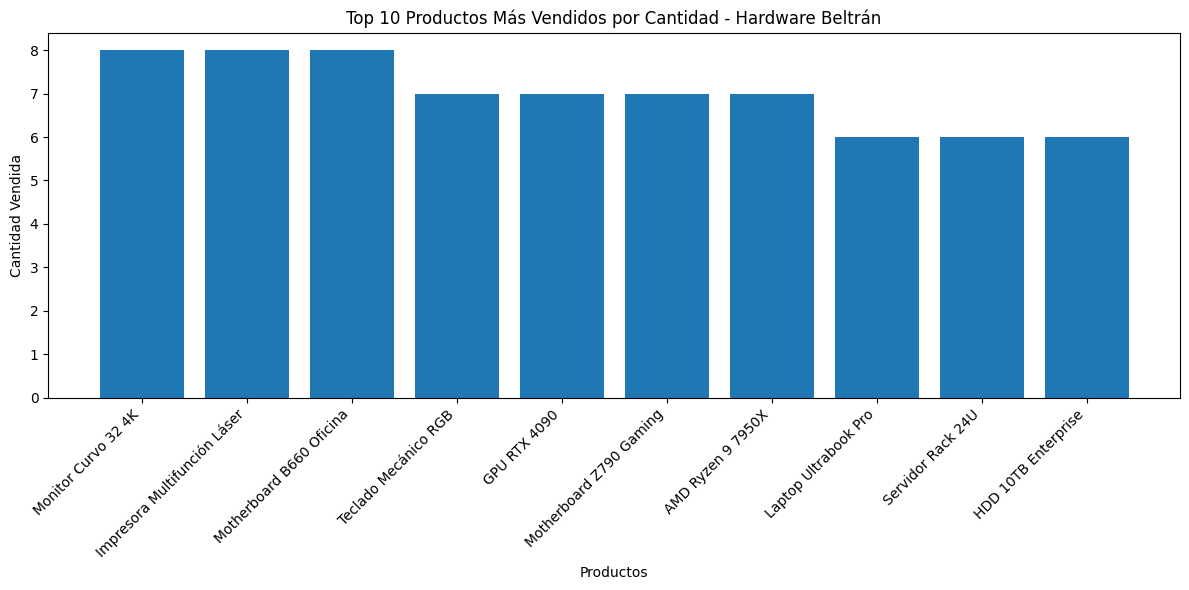

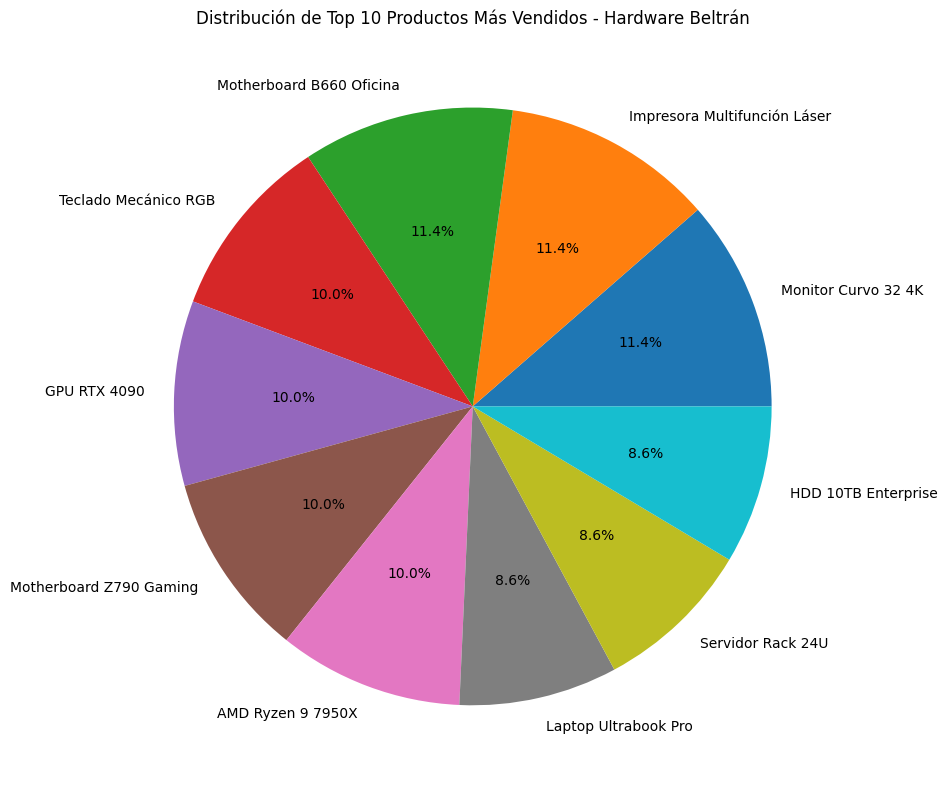

2. Generando ventas por rubro...


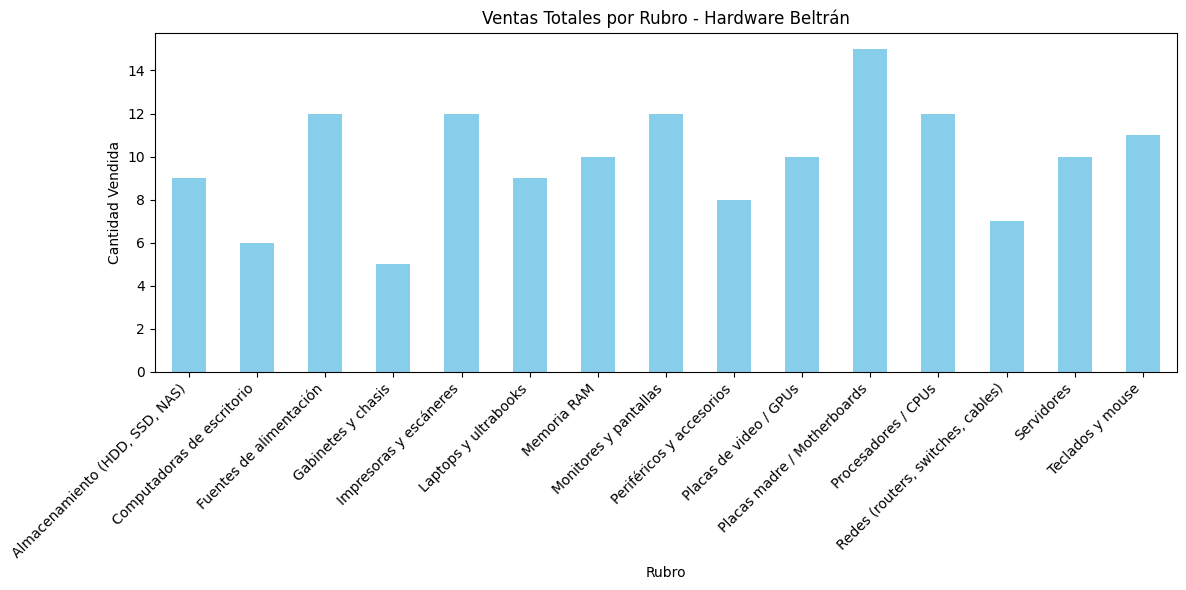

3. Generando ventas por mes...


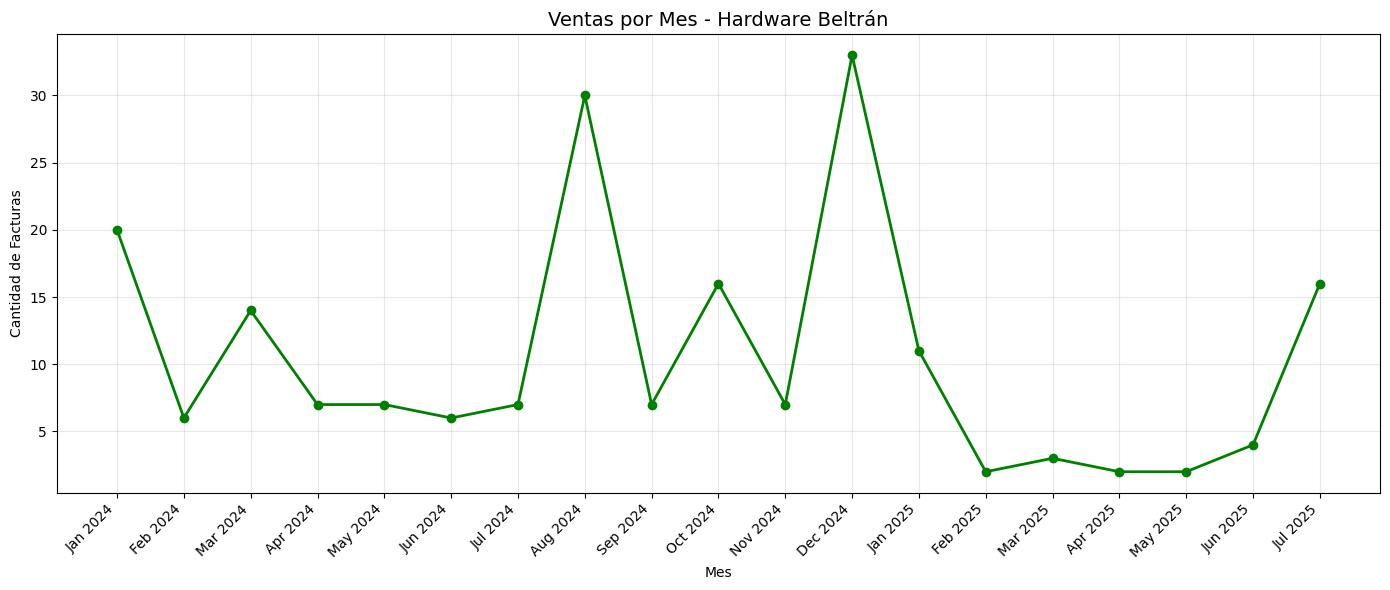

4. Generando ticket promedio...


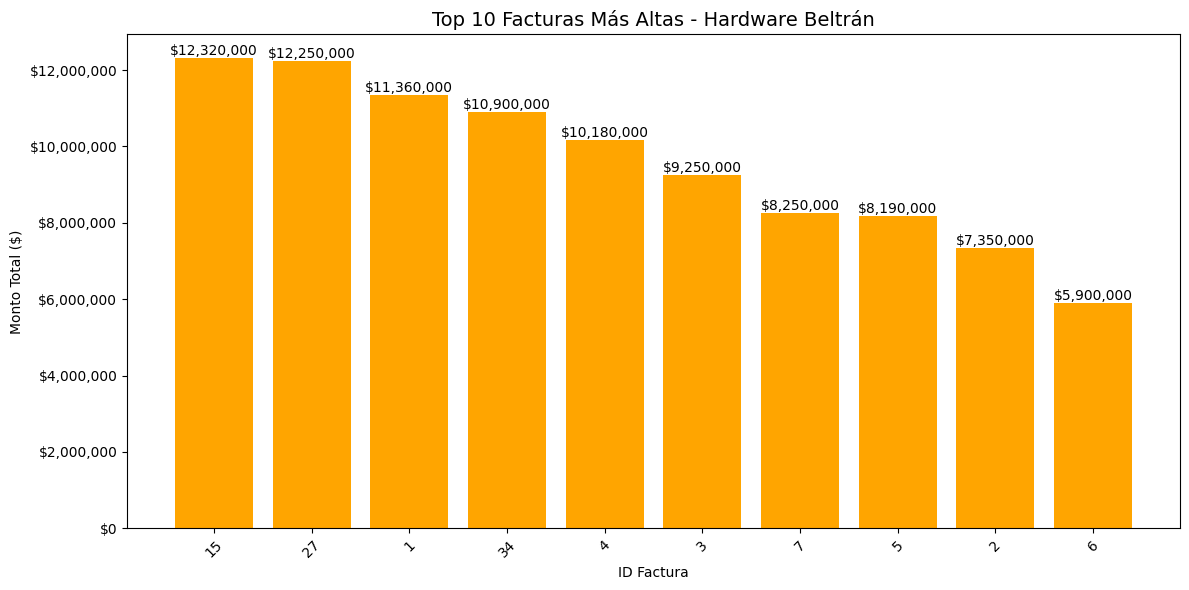

   Ticket promedio: $4,558,815.79
   Ticket máximo: $12,320,000.00
   Ticket mínimo: $335,000.00
5. Generando facturas más altas...


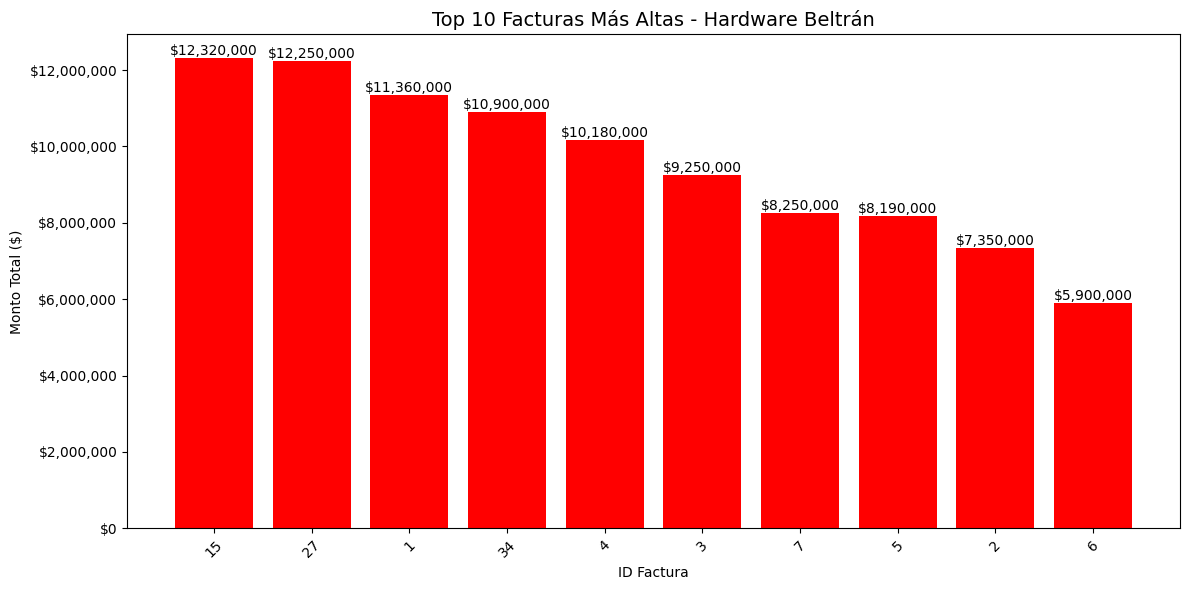

6. Generando producto más vendido...


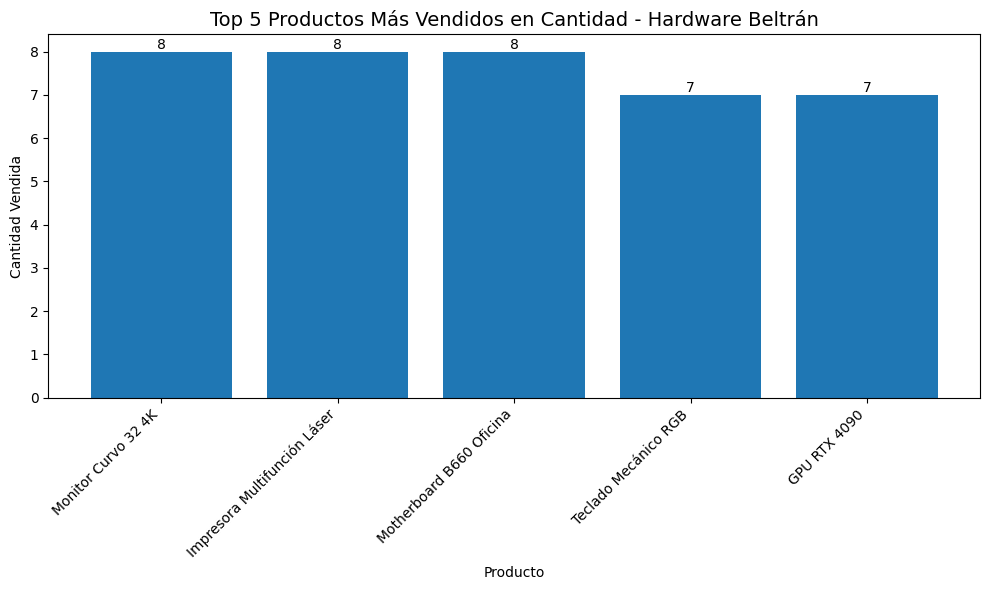

7. Generando análisis de ventas general...


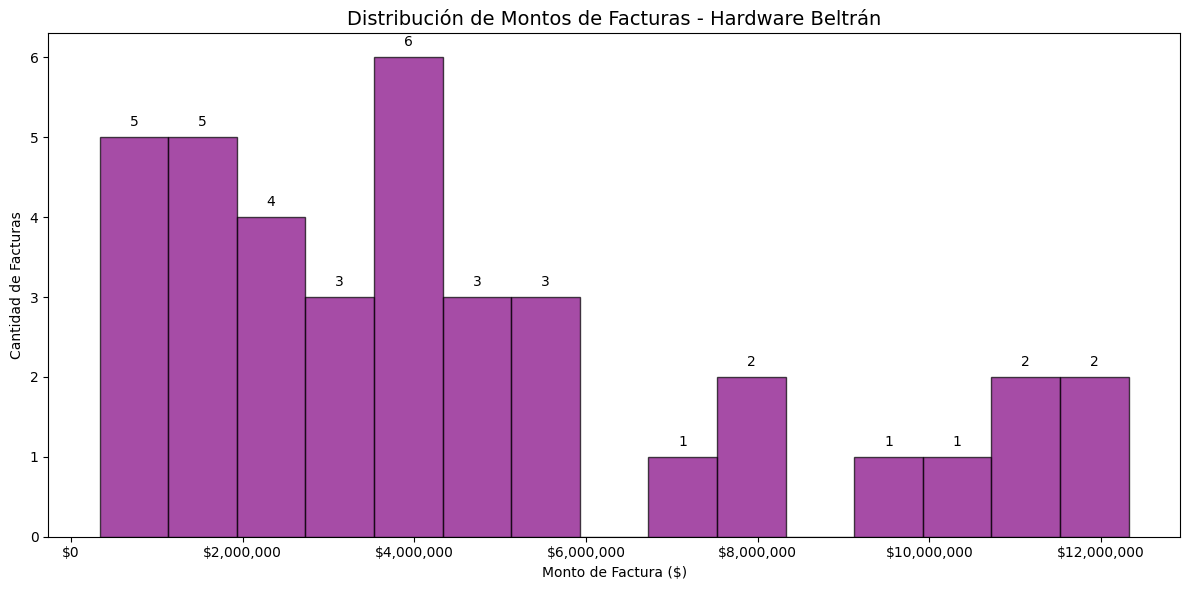

8. Generando análisis por sucursal...


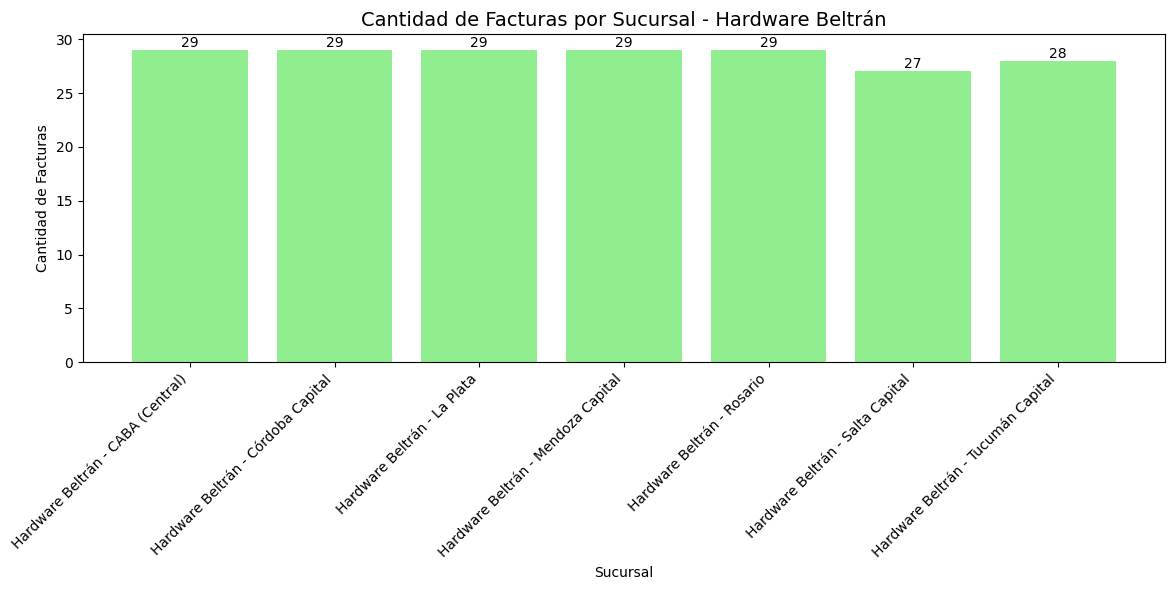


 📈 Se generaron 9 gráficos combinados:
   ✓ 01_top10_productos_barras.png
   ✓ 02_top10_productos_torta.png
   ✓ 03_ventas_por_rubro_barras.png
   ✓ 04_ventas_por_mes_lineal.png
   ✓ 05_ticket_promedio_barras.png
   ✓ 06_facturas_mas_altas_barras.png
   ✓ 07_producto_mas_vendido_barras.png
   ✓ 08_ventas_por_cliente_lineal.png
   ✓ 09_ventas_por_cliente_cantidad_barras.png

=== CREANDO INFORME COMBINADO ===
 ✓ Informe PDF generado: D:\Beltrán\Segundo año TS CD e IA\Modelizado de Minería de Datos\TSCIA_MMD\Proyecto_3\Informe_Combinado\Informe_Combinado_Completo.pdf

🎉 PROCESO FINALIZADO
 📂 Carpeta con Excels individuales: D:\Beltrán\Segundo año TS CD e IA\Modelizado de Minería de Datos\TSCIA_MMD\Proyecto_3\Excels_Individuales
 📊 Excel combinado: D:\Beltrán\Segundo año TS CD e IA\Modelizado de Minería de Datos\TSCIA_MMD\Proyecto_3\Datos_Combinados.xlsx
 📈 Gráficos combinados: D:\Beltrán\Segundo año TS CD e IA\Modelizado de Minería de Datos\TSCIA_MMD\Proyecto_3\Graficos_Combinados
 📄 Inf

In [22]:
# --- PROCESAMIENTO PRINCIPAL ---
print("=== INICIANDO PROCESAMIENTO ===")

# 1. Cargar todos los CSV con formato correcto
dataframes = cargar_tablas(archivos_csv)

# 2. Procesar CSV a Excel (individual y combinado)
print("\n=== CONVIRTIENDO CSV A EXCEL ===")
resumenes = []

try:
    with pd.ExcelWriter(salida_excel_combinado, engine="openpyxl") as writer_combinado:
        for nombre, df in dataframes.items():
            print(f" Procesando: {nombre}")
            
            # Guardar Excel individual
            ruta_excel_individual = os.path.join(carpeta_excels, f"{nombre}.xlsx")
            df.to_excel(ruta_excel_individual, index=False)
            print(f"   ✓ Excel individual: {ruta_excel_individual}")
            
            # Escribir en el Excel combinado
            # Limitar nombre de hoja a 31 caracteres (límite de Excel)
            nombre_hoja = nombre[:31]
            df.to_excel(writer_combinado, sheet_name=nombre_hoja, index=False)
            
            # Resumen estadístico
            resumen = df.describe(include="all").transpose()
            resumen["Archivo"] = nombre
            resumenes.append(resumen)

        # Guardar resumen general en el Excel combinado
        if resumenes:
            resumen_final = pd.concat(resumenes)
            resumen_final.to_excel(writer_combinado, sheet_name="Resumen_General")
            
    print(f" ✓ Excel combinado guardado: {salida_excel_combinado}")
    
    # Mostrar contenido del Excel combinado
    print(f"\n📊 CONTENIDO DEL EXCEL COMBINADO '{os.path.basename(salida_excel_combinado)}':")
    excel_file = pd.ExcelFile(salida_excel_combinado)
    for sheet_name in excel_file.sheet_names:
        df_sheet = pd.read_excel(salida_excel_combinado, sheet_name=sheet_name)
        print(f"   - Hoja '{sheet_name}': {len(df_sheet)} filas, {len(df_sheet.columns)} columnas")
    
except Exception as e:
    print(f"  Error guardando Excel combinado: {e}")

# 3. Generar gráficos combinados
print("\n=== GENERANDO GRÁFICOS COMBINADOS ===")
graficos_combinados = generar_graficos_combinados(dataframes, carpeta_graficos_combinados)

print(f"\n 📈 Se generaron {len(graficos_combinados)} gráficos combinados:")
for grafico in graficos_combinados:
    print(f"   ✓ {os.path.basename(grafico)}")

# 4. Crear informe PDF combinado
print("\n=== CREANDO INFORME COMBINADO ===")
if graficos_combinados:
    pdf_combinado = crear_informe_combinado(graficos_combinados, carpeta_informe_combinado, dataframes)
    print(f" ✓ Informe PDF generado: {pdf_combinado}")
else:
    print("  No se generaron gráficos para el informe")

print("\n" + "="*50)
print("🎉 PROCESO FINALIZADO")
print("="*50)
print(f" 📂 Carpeta con Excels individuales: {carpeta_excels}")
print(f" 📊 Excel combinado: {salida_excel_combinado}")
print(f" 📈 Gráficos combinados: {carpeta_graficos_combinados}")
print(f" 📄 Informe PDF combinado: {carpeta_informe_combinado}")
print(f" 📊 Total de gráficos generados: {len(graficos_combinados)}")